In [50]:
# (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

#general imports:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io
import sys, os, time
from skimage import data, filters, feature
from skimage.filters import gaussian
import scipy.ndimage
from skimage import data, color, measure, filters, morphology
from skimage.measure import label, regionprops
from skimage.morphology import dilation, disk
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 20})

#phastphase and jav related imports
import phastphase
from phastphase.retrieval_jax import retrieve

import jax
import jax.lax as lax
import jax.numpy as npj
#Make sure that the jax perscision is good!!
jax.config.update('jax_enable_x64', True)
import os
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)
jax.default_matmul_precision=jax.lax.Precision('highest')

import phasephase_helper_funcs as help_funcs
from experimental_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


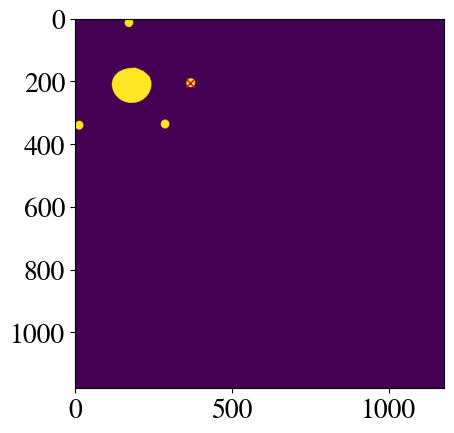

In [51]:
# Load the .mat file
experiment = scipy.io.loadmat('S1_d4_AG_Ropers_far_field_amplitudes.mat')
experiment_data = {}
experiment_data['far_field_L'] = experiment['F_ampL']
experiment_data['far_field_R'] = experiment['F_ampR']

ground_truth = scipy.io.loadmat('Recon_S1_d4_tmp.mat')
ground_truth_data = {}
ground_truth_data['F_ampL'] = ground_truth["F_ampL"]
ground_truth_data['F_ampR'] = ground_truth["F_ampR"]
ground_truth_data['psiL'] = ground_truth["psiL"]
ground_truth_data['psiR'] = ground_truth["psiR"]
ground_truth_data['support2'] = ground_truth["support2"]
ground_truth_mask = ground_truth_data['support2'].astype(float)

far_field_R_cropped, far_field_L_cropped = crop_far_field(experiment_data['far_field_R'], experiment_data['far_field_L'])
autocorrelated_mask_R = recover_autocorrelated_mask(far_field_R_cropped)
autocorrelated_mask_L = recover_autocorrelated_mask(far_field_L_cropped)

# FIXME: Are they different?
autocorrelated_mask = autocorrelated_mask_L

recovered_mask, reference_point = extract_mask_from_autocorrelation(autocorrelated_mask)
plt.imshow(recovered_mask)
plt.plot(reference_point[1], reference_point[0], 'xr')
plt.show()

Found 5 circles.


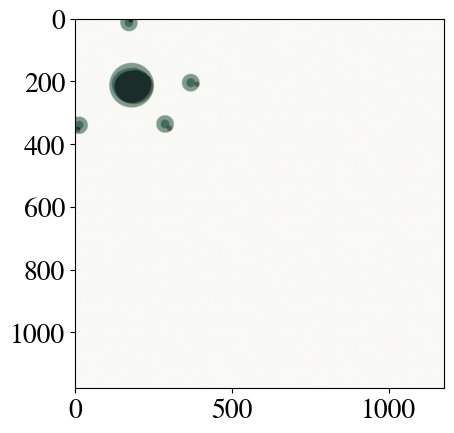

In [52]:
tight_ground_truth_support = help_funcs.bound_image(ground_truth_mask)
threshold_value_gt = filters.threshold_li(np.abs(ground_truth_data['psiL']))
binary_image_gt = np.abs(ground_truth_data['psiL']) > threshold_value_gt  # Threshold the image
min_row, min_col, max_row, max_col = help_funcs.get_bounds(binary_image_gt)


ground_truth_L_cropped = ground_truth_data['psiL'][min_row:max_row,min_col:max_col]
ground_truth_R_cropped = ground_truth_data['psiR'][min_row:max_row,min_col:max_col]
ground_truth_support_cropped = ground_truth_data['support2'][min_row:max_row,min_col:max_col]

ground_truth_L_padded = pad_for_far_field(ground_truth_L_cropped, far_field_L_cropped)
ground_truth_R_padded = pad_for_far_field(ground_truth_R_cropped, far_field_R_cropped)
ground_truth_support_padded = pad_for_far_field(ground_truth_support_cropped, far_field_L_cropped)

recovered_support_padded = pad_for_far_field(recovered_mask, far_field_L_cropped)
recovered_support_expanded_padded = expand_circles(recovered_support_padded, main_scale_factor=1.2, reference_scale_factor=2)

# print(ground_truth_support_cropped.shape)
# print(recovered_support_cropped.shape)
# print(recovered_support_expanded_cropped.shape)
# fig,ax = plt.subplots(1,2,figsize = (12,4))
#plt.imshow(ground_truth_data['support2'])
plt.imshow(ground_truth_support_padded, cmap='Reds')
plt.imshow(recovered_support_padded, cmap='Blues', alpha=0.5)
plt.imshow(recovered_support_expanded_padded, cmap='Greens', alpha=0.5)
plt.show()

In [ ]:
from skimage.measure import label, regionprops

props2 = regionprops(label(ground_truth_support_padded))
y,x = props2[2].centroid
x = int(x)
y = int(y)
reference_point_new = (y,x)
# (210, 387)

retrieval_far_field = np.fft.fftshift(far_field_L_cropped ** 2)
sergey_out, sergey_err = run_phastphase(
    ground_truth=ground_truth_L_cropped,
    far_field_oversampled=retrieval_far_field,
    support_mask=ground_truth_support_padded,
    winding_guess=reference_point_new,
)

print("Sergey's method error:", sergey_err)
plot_farfield(sergey_out,far_field_L_cropped)

Using winding numbers: (210, 387)


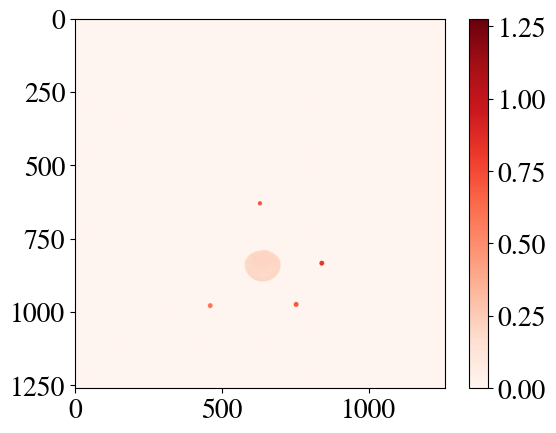

1

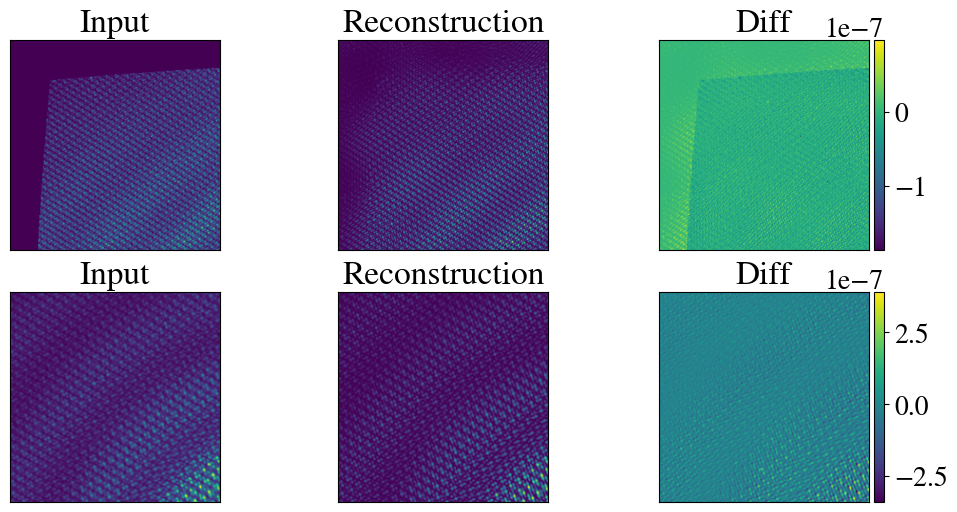

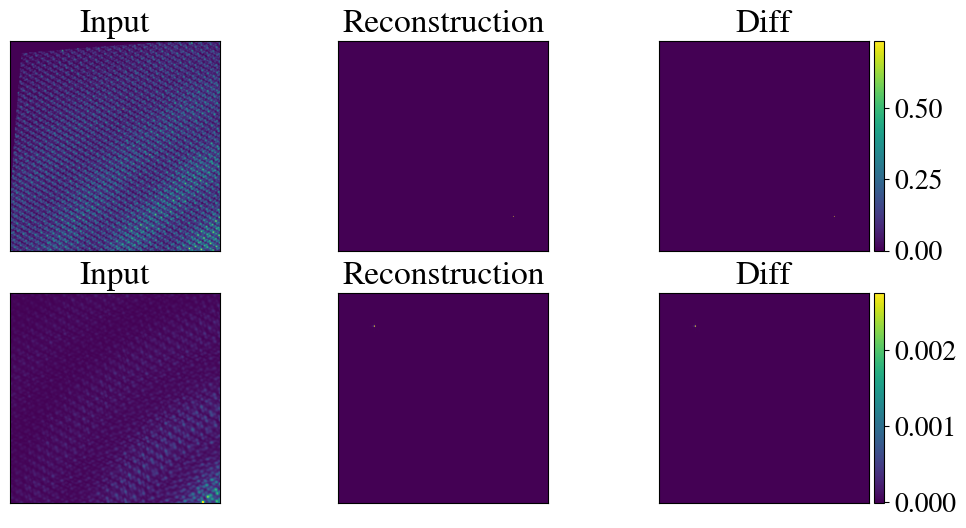

In [48]:
# print(sergey_out.shape)

plt.imshow(np.abs(ground_truth_data['psiL']), cmap='Reds')
plt.colorbar()
plt.show()

plot_farfield(ground_truth_data['psiL'], ground_truth_data['F_ampL'])
p = np.pad(ground_truth_L_cropped, ((0, 200), (0, 200)))
plot_farfield(ground_truth_data['F_ampL'][:500, :500], far_field_L_cropped)

Maximum Overlapping Pixels: 10925.000000000002
Shift required for B to match A: (y=-2, x=-7)


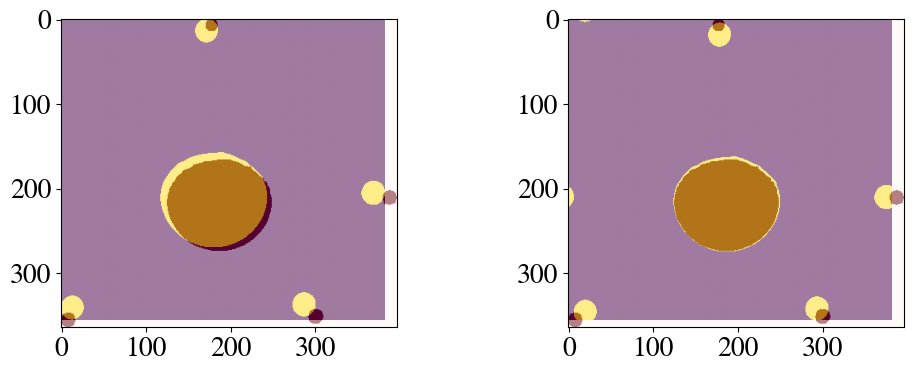

In [ ]:
tight_ground_truth_support = help_funcs.bound_image(ground_truth_data['support2'])
tight_support_box = help_funcs.bound_image(recovered_mask.astype(float))

dy, dx, overlap = find_max_overlap_offset(tight_ground_truth_support, tight_support_box)

print(f"Maximum Overlapping Pixels: {overlap}")
print(f"Shift required for B to match A: (y={dy}, x={dx})")

# shift_y and shift_x are the values you calculated previously
# axis=(0, 1) specifies (rows, columns)
support_rolled = np.roll(tight_support_box, shift=(-dy + 3, -dx), axis=(0, 1))

# support_rolled = np.roll(tight_support_box, shift=int(dy), axis=0)
# support_rolled = np.roll(support_rolled, shift=int(dx), axis=1)

fig,ax = plt.subplots(1,2,figsize = (12,4))
ax[0].imshow(tight_support_box)
ax[0].imshow(tight_ground_truth_support, cmap='Reds', alpha=0.5)

ax[1].imshow(support_rolled)
ax[1].imshow(tight_ground_truth_support, cmap='Reds', alpha=0.5)
plt.show()

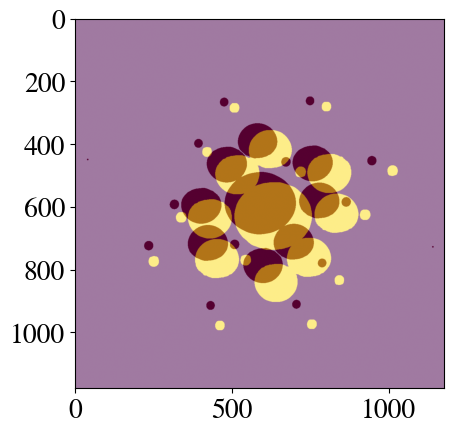

In [ ]:
# fft = help_funcs.Fourier(far_field_R_cropped**2)
# logfft = np.log(np.abs(fft))
# threshold_value = filters.threshold_li(logfft)
# binary_image = logfft > threshold_value  # Threshold the image

# gt_far_field_fft = np.log(np.abs(np.fft.ifft2(np.abs(np.fft.fft2(tight_ground_truth_support))**2)))

# gt_fft = help_funcs.Fourier(gt_far_field_fft)
# gt_logfft = np.log(np.abs(gt_fft))
# gt_threshold_value = filters.threshold_li(gt_logfft)
# gt_binary_image = gt_logfft > gt_threshold_value  # Threshold the image

#tight_ground_truth_support = help_funcs.bound_image(ground_truth_data['support2'])

#tight_support_box = tight_support_box.astype(float)

# dy, dx, overlap = find_max_overlap_offset(tight_ground_truth_support, binary_image)

# print(f"Maximum Overlapping Pixels: {overlap}")
# print(f"Shift required for B to match A: (y={dy}, x={dx})")

# # shift_y and shift_x are the values you calculated previously
# # axis=(0, 1) specifies (rows, columns)
# support_rolled = np.roll(binary_image, shift=(-dy, -dx), axis=(0, 1))

# support_rolled = np.roll(tight_support_box, shift=int(dy), axis=0)
# support_rolled = np.roll(support_rolled, shift=int(dx), axis=1)




recorrelated_mask = recorrelate(ground_truth_data['support2'])


# fig,ax = plt.subplots(1,2,figsize = (12,4))
plt.imshow(recorrelated_mask)
plt.imshow(binary_image, cmap='Reds', alpha=0.5)

# ax[1].imshow(support_rolled)
# ax[1].imshow(tight_ground_truth_support, cmap='Reds', alpha=0.5)
plt.show()

Maximum Overlapping Pixels: 123148.00000000004
Shift required for B to match A: (y=-41, x=-43)


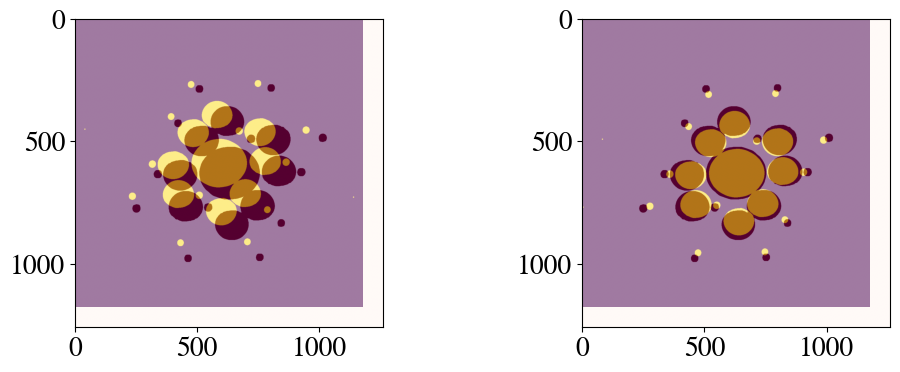

In [ ]:
dy, dx, overlap = find_max_overlap_offset(recorrelated_mask, binary_image)

print(f"Maximum Overlapping Pixels: {overlap}")
print(f"Shift required for B to match A: (y={dy}, x={dx})")

# shift_y and shift_x are the values you calculated previously
# axis=(0, 1) specifies (rows, columns)
support_rolled = np.roll(binary_image, shift=(-dy, -dx), axis=(0, 1))

# support_rolled = np.roll(tight_support_box, shift=int(dy), axis=0)
# support_rolled = np.roll(support_rolled, shift=int(dx), axis=1)

fig,ax = plt.subplots(1,2,figsize = (12,4))
ax[0].imshow(binary_image)
ax[0].imshow(recorrelated_mask, cmap='Reds', alpha=0.5)

ax[1].imshow(support_rolled)
ax[1].imshow(recorrelated_mask, cmap='Reds', alpha=0.5)
plt.show()

Maximum Overlapping Pixels: 11349.00000000001
Shift required for B to match A: (y=-180, x=34)


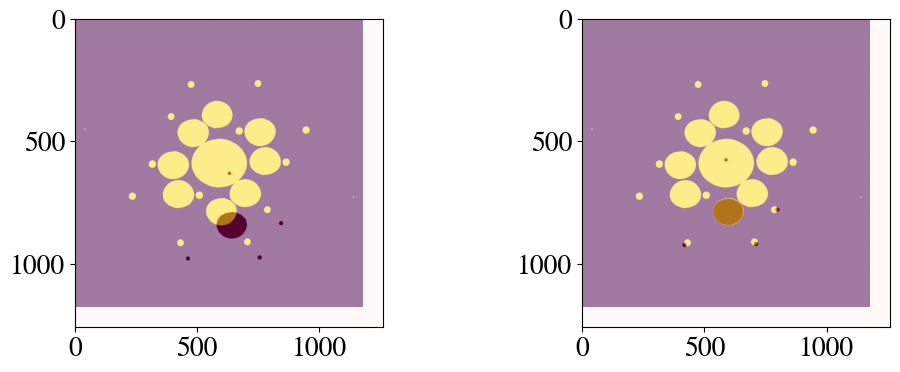

In [ ]:
# Define a structuring element
#structuring_element = morphology.disk(0)  # Circular structuring element with radius 5

# Perform dilation to enlarge the shapes
#support_large = morphology.dilation(support, structuring_element)

binary_image = binary_image.astype(float)
a = ground_truth_data['support2']

dy, dx, overlap = find_max_overlap_offset(binary_image, a)

print(f"Maximum Overlapping Pixels: {overlap}")
print(f"Shift required for B to match A: (y={dy}, x={dx})")

# shift_y and shift_x are the values you calculated previously
# axis=(0, 1) specifies (rows, columns)
support_rolled = np.roll(a, shift=(dy + 125, dx-75), axis=(0, 1))

# support_rolled = np.roll(tight_support_box, shift=int(dy), axis=0)
# support_rolled = np.roll(support_rolled, shift=int(dx), axis=1)

fig,ax = plt.subplots(1,2,figsize = (12,4))
ax[0].imshow(binary_image)
ax[0].imshow(a, cmap='Reds', alpha=0.5)

ax[1].imshow(binary_image)
ax[1].imshow(support_rolled, cmap='Reds', alpha=0.5)
plt.show()

In [ ]:
# phastphase_out, phastphase_err = run_phastphase(
#     ground_truth=ground_truth_data['psiL'][min_row:max_row,min_col:max_col],
#     far_field_oversampled=far_field_L_cropped,
#     support_mask=new_mask1,
#     winding_guess=reference_point_new,
# )

# print("Sergey's method error:", sergey_err)
#plot_farfield(sergey_out,far_field_L_cropped)